# 03 ImageClustering using PCA, Kmeans, DBSCAN


![Assets/dbscan_graph.png](Assets/dbscan_graph.png)


## Learning Objectives

* Explore and interpret the image dataset

* Apply Intel® Extension for Scikit-learn* patches to Principal Components Analysis (PCA), Kmeans,and DBSCAN algorithms and target GPU

## Library Dependencies:

 - **pip install pickle**
 - **pip install pillow**
 - **pip install seaborn**
 - also requires these libraries if they are not already installed: **matplotlib, numpy, pandas, sklearn**

<a id='Back_to_Sections'></a>

## Sections

- _Code:_ [Read Images](#Define-image-manipulation-and-Reading-functions)
- _Code:_ [Submit batch_clustering_Streamlined.py as a batch job](#Submit-batch_clustering_Streamlined.py-as-a-batch-job)
- _Code:_ [Read the results of the dictionary after GPU computation](#Read-the-results-of-the-dictionary-after-GPU-computation)
- _Code:_ [Plot Kmeans using GPU results](#Plot-Kmeans)
- _Code:_ [Plot DBSCAN using GPU results](#Plot-DBSCAN)


In [1]:
from __future__ import print_function
data_path = ['data']

# Notebook time start
from datetime import datetime

start_time = datetime.now()

current_time = start_time.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 20:40:26


# Define image manipulation and Reading functions


In [2]:
from lab.Read_Transform_Images import *


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


<a id='Actually-read-the-images'></a>
# Actually read the images

- [Back to Sections](#Back_to_Sections)

In [3]:
resultsDict = {}
#resultsDict = Read_Transform_Images(resultsDict,imagesFilenameList = imagesFilenameList)
resultsDict = Read_Transform_Images(resultsDict)
#resultsDict.keys()

Running Read_Transform_Images on CPU: 


# Display ImageGrid Random Sampling

This should give an idea of how closely or differently the various images appear. Notice that some of the collard lizard images have much differnet white balance and this will affect the clustering. For this dataset the images are clustered based on the similarity in RGB colorspace only.

(24, 480, 640, 3)


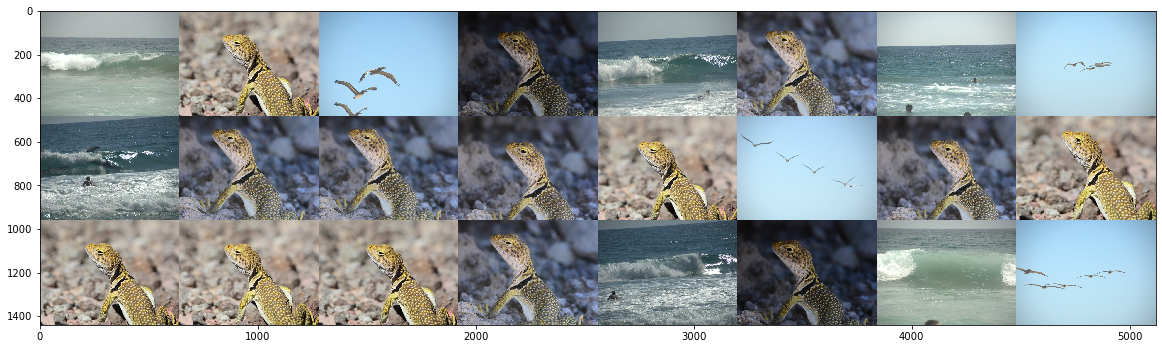

In [4]:
img_arr = []
ncols = 8
imageGrid=(ncols,3)
for pil in random.sample(resultsDict['list_PIL_Images'], imageGrid[0]*imageGrid[1])  :
    img_arr.append(np.array(pil))
#displayImageGrid(img_arr, imageGrid=imageGrid)
displayImageGrid2(img_arr, ncols=ncols)

<a id='Review_python_batch_file_prior_to_submission'></a>

# Review Python file prior to submission
### Set SYCL Device Context


- [Back to Sections](#Back-to-Sections)

Paste this code in cell below and run it (twice) once to load, once to execute the cell:

%load batch_clustering_Streamlined.py

In [5]:
# %load batch_clustering_Streamlined.py
# batch_clustering_Streamlined.py


#===============================================================================
# Copyright 2014-2021 Intel Corporation
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#===============================================================================

from sklearnex import patch_sklearn
patch_sklearn()

import matplotlib.pyplot as plt
import numpy as np
import glob
from PIL import Image
from PIL.Image import Image as PilImage
#from skimage.color import rgb2hsv
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import pandas as pd
import random
import operator
import seaborn as sns
import json

def ReshapeShortFat(original):
    """
    ReshapeShortFat(original)
    
    Reshapes the image numpy array from original shape 
    to the ShortFat single row shape and captures
    shape info in the output:
    channel_0, channel_1, channel_2
    
    functionally performs original.reshape(1, x*y*z) to create single row vector
    
    inputs:
        original - input the original image array
    
    return:
        ShortFatArray
        channel_0 - dimensions of the first channel - possibly the Red channel if using RGB
        channel_1 - dimensions of the first channel - possibly the Green channel if using RGB
        channel_2 - dimensions of the first channel - possibly the Blue channel if using RGB
    """       
    # preserve shape of incoming image
    channel_0, channel_1, channel_2 = original.shape
    #print('a shape ', a.shape)

    # convert to short, fat array
    ShortFatArray = original.reshape(1, channel_0*channel_1*channel_2)

    #print('a1 shape ', a1.shape)
    return ShortFatArray.squeeze(), channel_0, channel_1, channel_2

def Read_Transform_Images(resultsDict, 
                         imagesFilenameList = [], 
                         FSWRITE = False): 
    print('Running Read_Transform_Images on CPU: ')
    imageToClusterPath = 'data/'
    if len(imagesFilenameList) == 0:
        imagesFilenameList = [f for f in 
            sorted(glob.glob(imageToClusterPath 
            + '*.jpg'))]

    list_np_Images = []
    list_PIL_Images = []
    for im in imagesFilenameList:
        img =  Image.open(im)
        list_PIL_Images.append(img)
        a = np.asarray(img,dtype=np.float32)/255
        with np.errstate(divide='ignore', invalid='ignore'):
            #a1, x, y, z = ReshapeShortFat(rgb2hsv(a))
            a1, x, y, z = ReshapeShortFat(a)
        a2 = a1  # no image whitening for each file
        list_np_Images.append(a2)
    NP_images = np.array(list_np_Images)
    NP_images_STD = StandardScaler(with_std=True).fit_transform(NP_images)
    resultsDict['imagesFilenameList'] = imagesFilenameList
    resultsDict['list_PIL_Images'] = list_PIL_Images
    resultsDict['NP_images_STD'] = NP_images_STD
    if FSWRITE == True:
        write_results(resultsDict)
    return resultsDict

def displayImageGrid(img_arr, imageGrid=(4,5)):
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import ImageGrid
    import numpy as np
    import random

    fig = plt.figure(figsize=(20,20))
    grid = ImageGrid(fig, 111, 
                     nrows_ncols=imageGrid,  # creates 2x2 grid of axes
                     #axes_pad=0.1,  # pad between axes
                     )

    img_arr = np.array(img_arr)
    for ax, im in zip(grid, img_arr):
         ax.imshow(im)

    plt.show()
   
    
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
def write_results_json(resultsDict):
    if 'list_PIL_Images' in resultsDict.keys():
        del resultsDict['list_PIL_Images']
    if 'NP_images_STD' in resultsDict.keys():
        del resultsDict['NP_images_STD']
    with open("results/resultsDict.json", "w") as outfile:
        json.dump(resultsDict, outfile, cls=NumpyEncoder)

def read_results_json():
    with open('results/resultsDict.json') as json_file:
        resultsDict = json.load(json_file)
    return resultsDict

def main():
    # determine if GPU available:
    dpctl_available = False
    try:
        # modern approach for SYCL context is to use dpctl & sklearnex._config supported in 
        # Intel(R) Extension for Scikit-learn* 2021.4 
        import dpctl
        from sklearnex._config import config_context
        dpctl_available = True
    except ImportError:
        try:
            # older approach for SYCL context is to use dall4py  
            from daal4py.oneapi import sycl_context
            print("*" * 80)
            print("\ndpctl package not found, switched to daal4py package\n")
            print("*" * 80)
        except ImportError:
            print("\nRequired packages not found, aborting...\n")
            exit()

    gpu_available = False
    if dpctl_available:
        try:
            with config_context(target_offload='gpu'):
                gpu_available = True
                def get_context(device):
                    return config_context(target_offload=device)
        except Exception:
            gpu_available = False
    else:
        try:
            with sycl_context('gpu'):
                gpu_available = True
                def get_context(device):
                     return sycl_context(device)
        except Exception:
            gpu_available = False
        
    # It is possible to specify to make the computations on GPU
    if gpu_available:
        with get_context('gpu'):
            print('Running on GPU ') 
    else:
        print('Running on CPU ')

    resultsDict = {}
    resultsDict = Read_Transform_Images(resultsDict)
    knee = 6
    EPS = 350
    n_components = 6
    n_samples = 3
    NP_images_STD = resultsDict['NP_images_STD'] # images as numpy array
    # It is possible to specify to make the computations on GPU
    if gpu_available:
        print('Running Compute PCA on GPU: ')   
        device_context = 'gpu'
        with  get_context('gpu'):           
            pca = PCA(n_components=n_components)
            PCA_fit_transform = pca.fit_transform(NP_images_STD) 
            k_means = KMeans(n_clusters = knee, init='random')
            db = DBSCAN(eps=EPS, min_samples = n_samples).fit(PCA_fit_transform)
            km = k_means.fit(PCA_fit_transform)
    # It is possible to specify to make the computations on CPU
    else:
        print('Running Compute PCA on local CPU: ')
        pca = PCA(n_components=n_components)
        PCA_fit_transform = pca.fit_transform(NP_images_STD) 
        k_means = KMeans(n_clusters = knee, init='random')
        db = DBSCAN(eps=EPS, min_samples = n_samples).fit(PCA_fit_transform)
        km = k_means.fit(PCA_fit_transform) 

    resultsDict['device_context'] = device_context
    resultsDict['imageClusters_db'] = len(np.unique(db.labels_))
    resultsDict['counts_db'], resultsDict['bins_db']  = np.histogram(db.labels_, bins = EPS)
    resultsDict['counts'], resultsDict['bins'] =np.histogram(k_means.labels_, bins = knee)    
    resultsDict['imageClusters'] = len(np.unique(km.labels_))
    resultsDict['km_labels'] = km.labels_
    resultsDict['db_labels'] = db.labels_
    resultsDict['PCA_fit_transform'] = PCA_fit_transform
    
    
    write_results_json(resultsDict)
    
    print("Kmeans bins   ", resultsDict['bins'])
    print("Kmeans counts ", resultsDict['counts'])
    
    print("All good inside main\n")
    
    return resultsDict

if __name__ == "__main__":
    resultsDict = main()
    #print("km_list: ", resultsDict['km_list'][0:2])
    print('All looks good!\nRun 03_Plot_GPU_Results.ipynb to graph the results!')

# Notices & Disclaimers 

# Intel technologies may require enabled hardware, software or service activation.
# No product or component can be absolutely secure.

# Your costs and results may vary.

# © Intel Corporation. Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries. 
# *Other names and brands may be claimed as the property of others.



Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Running on GPU: 
Running Read_Transform_Images on CPU: 
Running Compute PCA on GPU: 
Kmeans bins    [0.         0.83333333 1.66666667 2.5        3.33333333 4.16666667
 5.        ]
Kmeans counts  [4 4 3 5 3 7]
All good inside main

All looks good!
Run 03_Plot_GPU_Results.ipynb to graph the results!


<a id='Submit-batch_clustering_Streamlined.py-as-a-batch-job'></a>
# Submit batch_clustering_Streamlined.py

- [Back to Sections](#Back_to_Sections)

batch_clustering_Streamlined.py executed with a Python* command inside a shell script - run_clustering_streamlined.sh.

run_clustering_streamlined.sh is submitted as a batch job to a node which has GPUs

In [6]:
#!python batch_kmeans.py   # works on Windows
! chmod 755 q; chmod 755 run_clustering_streamlined.sh; if [ -x "$(command -v qsub)" ]; then ./q run_clustering_streamlined.sh; else ./run_clustering_streamlined.sh; fi

## ac.chesebrough is compiling AI Essentials Module1 -- DPPY kmeans gpu - 1 of 2 batch_clustering_Streamlined.py
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Running Read_Transform_Images on CPU: 
Running ComputePCA on local CPU: 
Kmeans bins    [0.         0.83333333 1.66666667 2.5        3.33333333 4.16666667
 5.        ]
Kmeans counts  [3 3 7 6 3 4]
All good inside main

All looks good!
Run 03_Plot_GPU_Results.ipynb to graph the results!


<a id='Read-the-results-of-the-dictionary-after-GPU-computation'></a>
# Read Results of the Dictionary After GPU Computation

- [Back to Sections](#Back_to_Sections)


In [7]:
# read results from json file in results folder
resultsDict = read_results_json()
# get list_PIL_Images from Read_Tansform_Images
resultsDict = Read_Transform_Images(resultsDict)

Running Read_Transform_Images on CPU: 


<a id='Plot-Kmeans'></a>
# Plot Kmeans Clusters 

Plot a histogram of the using GPU results
-  [Back to Sections](#Back_to_Sections)

In [8]:
resultsDict.keys()

dict_keys(['imagesFilenameList', 'device_context', 'imageClusters_db', 'counts_db', 'bins_db', 'counts', 'bins', 'imageClusters', 'km_labels', 'db_labels', 'PCA_fit_transform', 'list_PIL_Images', 'NP_images_STD'])

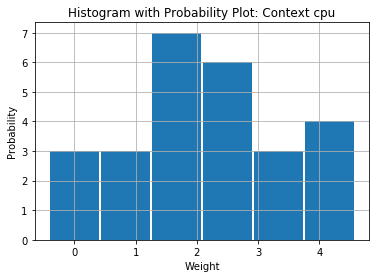

In [9]:
#resultsDict = Compute_kmeans_db_histogram_labels(resultsDict, knee = 6, gpu_available = gpu_available) #knee = 5
counts = np.asarray(resultsDict['counts'])
bins = np.asarray(resultsDict['bins'])
plt.xlabel("Weight")
plt.ylabel("Probability")
plt.title("Histogram with Probability Plot: Context {}".format(resultsDict['device_context']))
slice = min(counts.shape[0], bins.shape[0])
plt.bar(bins[:slice],counts[:slice])
plt.grid()
plt.show()

# Print Kmeans Related Data as a Sanity Check

In [10]:
print(resultsDict['bins'])
print(resultsDict['counts'])
resultsDict.keys()

[0.0, 0.8333333333333334, 1.6666666666666667, 2.5, 3.3333333333333335, 4.166666666666667, 5.0]
[3, 3, 7, 6, 3, 4]


dict_keys(['imagesFilenameList', 'device_context', 'imageClusters_db', 'counts_db', 'bins_db', 'counts', 'bins', 'imageClusters', 'km_labels', 'db_labels', 'PCA_fit_transform', 'list_PIL_Images', 'NP_images_STD'])

# Display Similar Images

Visually compare image which have been clustered by the allgorithm

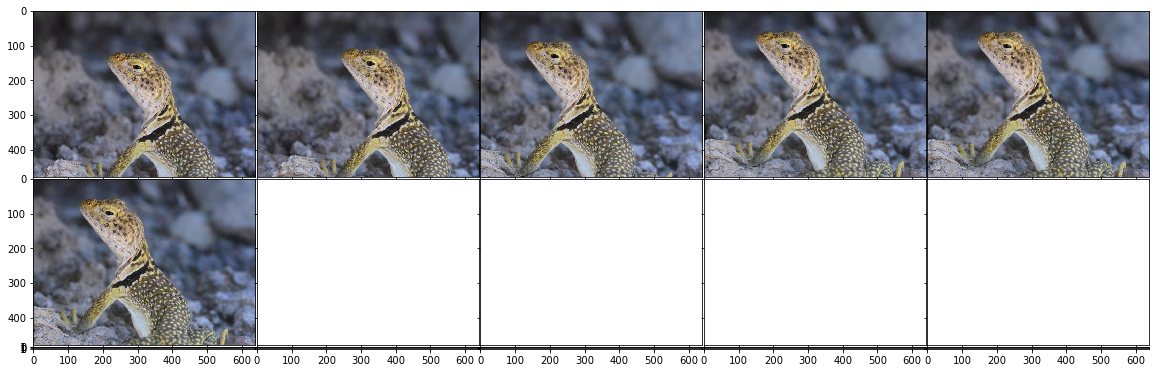

In [11]:
clusterRank = 1
d = {i:cts for i, cts in enumerate(resultsDict['counts'])}
sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)

id = sorted_d[clusterRank][0]
indexCluster = np.where(np.asarray(resultsDict['km_labels']) == id  )[0].tolist()
img_arr = []
for idx in indexCluster:
    img_arr.append(np.array((resultsDict['list_PIL_Images'][idx])))
img_arr = np.asarray(img_arr)
displayImageGrid(img_arr)

# PlotPlot Seaborn Kmeans Clusters

Indicates numbers of images that are close in color space

<Figure size 576x576 with 0 Axes>

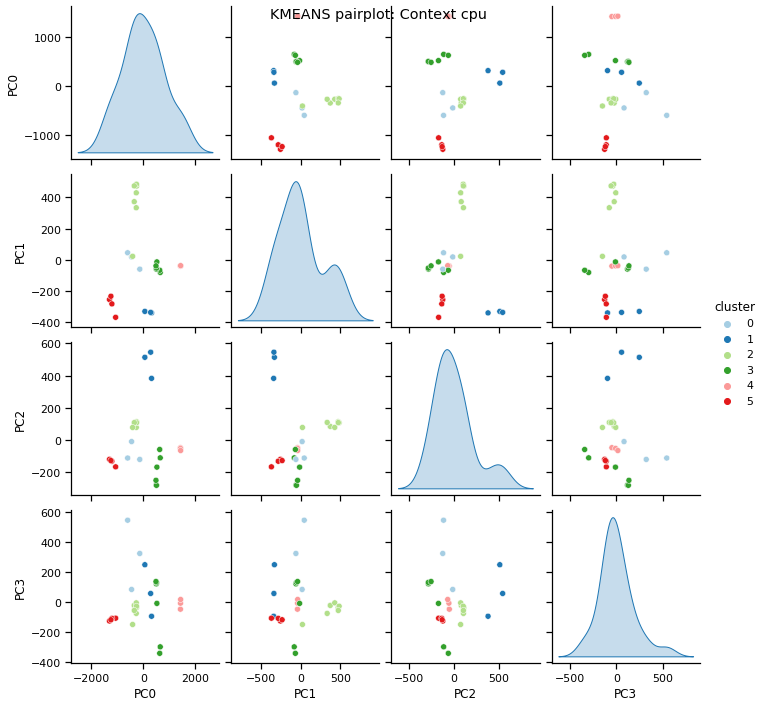

In [12]:
%matplotlib inline

n_components = 4

columns = ['PC{:0d}'.format(c) for c in range(n_components)]
data = pd.DataFrame(np.asarray(resultsDict['PCA_fit_transform'])[:,:n_components], columns = columns)
#k_means = resultsDict['model']
data['cluster'] = resultsDict['km_labels']
data.head()
# similarlyNamedImages = [9,6,6,8,6,4,8,3]
# print('number of similarly named images: ', similarlyNamedImages)

columns.append('cluster')
plt.figure(figsize=(8,8))

sns.set_context('notebook');
g = sns.pairplot(data[columns], hue="cluster", palette="Paired", diag_kws=dict(hue=None));
g.fig.suptitle("KMEANS pairplot: Context {}".format(resultsDict['device_context']));

# Find DBSCAN EPS parameter

Density-Based Spatial Clustering of Applications with Noise (DBSCAN) finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density.

EPS: "epsilon" value in sklearn is the maximum distance between two samples for one to be considered as in the neighborhood of the other.

At least a first value to start. We are using kNN to find distances commonly occuring in the dataset. Values of EPS below this threshold distance will be considered as lyig within a given cluster. This means we should look for long flat plateaus and read the y coordinate off the kNN plot to get a starting value for EPS.

Different datasets can have wildly different sweet spots for EPS. Some datasets require EPS values of .001 other datasets may work best with values of EPS of several thousand. We use this trick to get in the right or approximate neighborhood of the EPS.


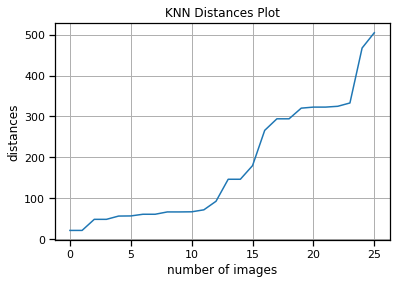

In [13]:
from sklearn.neighbors import NearestNeighbors

PCA_images = resultsDict['PCA_fit_transform']

neighbors = NearestNeighbors(n_neighbors=2)
#X = StandardScaler().fit_transform(PCA_images)
neighbors_fit = neighbors.fit(PCA_images)
distances, indices = neighbors_fit.kneighbors(PCA_images)

distances = np.sort(distances, axis=0)
plt.xlabel('number of images')
plt.ylabel('distances')
plt.title('KNN Distances Plot')
plt.plot(distances[:,1])
plt.grid()

# Use DBSCAN to find clusters

we will use initial estiamtes from KNN above (find elbow) to given initial trial for DBSCAN EPS values 

In the plot above, there is a plateau in the y values somewherre near 350 indicating that a cluster distance (aka EPS) might work well somewhere near this value. We used this value in the batch_clustering_Streamlined.py file when computing DBSCAN.

**EPS:** Two points are  neighbors if the distance between the two points is below a threshold.
**n:** The minimum number of neighbors a given point should have in order to be classified as a core point. 
The point itself is included in the minimum number of samples.

# Below: Sort DBSCAN Results by Cluster Size

In [14]:
#%%write_and_run    lab/compute_DBSCANClusterRank.py 
def compute_DBSCANClusterRank(n, EPS):
    d = {index-1:int(cnt) for index, cnt in enumerate(counts )}
    sorted_d = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
    for i in range(0, len(d)):
        idx = sorted_d[i][0]
        print('cluster = ', idx, ' occurs', int(sorted_d[i][1]), ' times')
    return db, counts, bins, sorted_d

n_components = 4

columns = ['PC{:0d}'.format(c) for c in range(n_components)]
data = pd.DataFrame(np.asarray(resultsDict['PCA_fit_transform'])[:,:n_components], columns = columns)

columns.append('cluster')
data['cluster'] = resultsDict['db_labels'] 
data.head()

,PC0,PC1,PC2,PC3,cluster
0,1426.001221,-41.071781,-48.359638,-48.855717,0
1,1428.941528,-39.572861,-52.906162,-8.649530,0
2,1433.676147,-38.217281,-65.988342,15.947206,0
3,648.598633,-81.985771,-111.420105,-299.914673,-1
4,628.590515,-67.587341,-59.532368,-343.086395,-1


<a id='Plot-DBSCAN'></a>
# DBSCAN Cluster Plot

Plot a histogram of the using GPU results
- [Back to Sections](#Back_to_Sections)

 

To indicate numbers of images in each cluster. color each point by its membership in a cluster

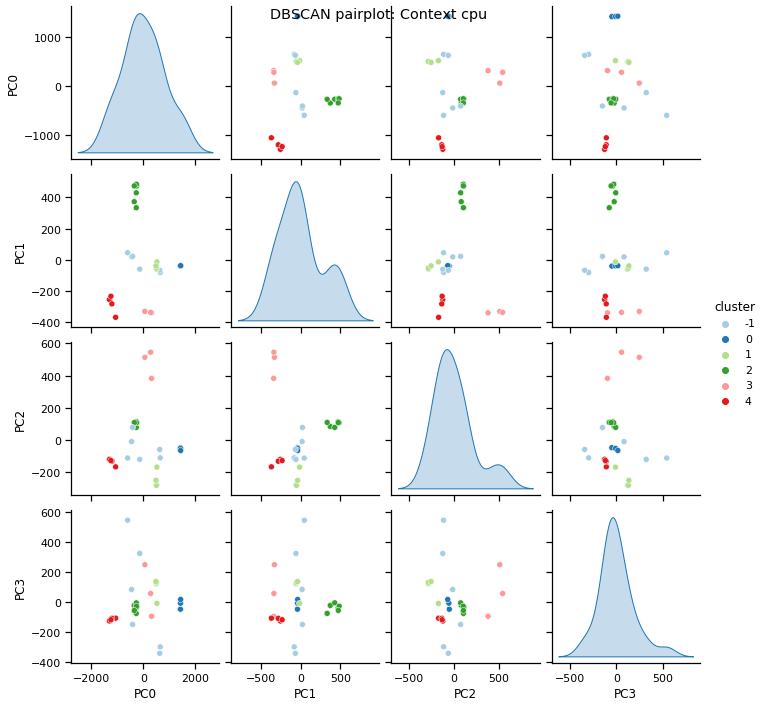

In [15]:
%matplotlib inline

sns.set_context('notebook');
g = sns.pairplot(data[columns], hue="cluster", palette="Paired", diag_kws=dict(hue=None));
g.fig.suptitle("DBSCAN pairplot: Context {}".format(resultsDict['device_context']));

# Print Filenames of Outliers

In [16]:
print('Outlier/problematic images are: \n', 
      [resultsDict['imagesFilenameList'][f] for f in list(data[data['cluster'] == -1].index)]
     )

Outlier/problematic images are: 
 ['data/Collard lizard dark white balance (20).jpg', 'data/Collard lizard dark white balance (21).jpg', 'data/Ocean Waves (2).jpg', 'data/Ocean Waves (4).jpg', 'data/Ocean Waves (7).jpg', 'data/Ocean Waves (8).jpg']


# Final Thoughts and next steps...

You may have noticed how difficult it is to get decent clustering on even 30 or 40 images using only RGB or HSV as the feature set
.
If all the images are well separated in either RGB, or HSV color space, then these features are useful for clustering.

However, a suggested next step—or next training—would be to encode the data differently. Perhaps using image classification with VGG16, but removing the last layer as a preprocess prior to k-means or DBSCAN.


.

# Notices & Disclaimers 

Intel technologies may require enabled hardware, software or service activation.
No product or component can be absolutely secure.

Your costs and results may vary.

© Intel Corporation. Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries. 
*Other names and brands may be claimed as the property of others.

